# Modeling

In [23]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, plot_confusion_matrix
from IPython.core.display import display, HTML
from sklearn.multiclass import OneVsRestClassifier #import classifier to for Logistic Multiclass problem
from sklearn.linear_model import LogisticRegression #import classifier
from sklearn.model_selection import RandomizedSearchCV #import Randomized search CV
from sklearn.ensemble import RandomForestClassifier

import pickle # to export/save models


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings('ignore')

In [3]:
X =pd.read_csv('../data/interim/explantorydf.csv', index_col=0) #read in features and target(s)
y = pd.read_csv('../data/interim/targetdf.csv', index_col=0)

In [4]:
y_fatal= y['Fatal'] # just the fatal class ( binary 0/1)

In [89]:
#split X and Y Fatal
X_train, X_test, y_train, y_test = train_test_split(X, y_fatal, test_size=0.30, random_state=42)


In [10]:
#checking sizes/shapes of splits
y_test.value_counts(), y_train.value_counts()


(0    608524
 1      8240
 Name: Fatal, dtype: int64,
 0    1420075
 1      19038
 Name: Fatal, dtype: int64)

# First - Logistic - Just on the Fatal Category

At the start of modeling I just wanted to investigate the "Fatal" category, being able to predict which accidents, will result in a fatality.

Above I have brought in my imports, and create a binary target response variable representing fatalities, and split the data in the train and test sets.

Instantiate logistic model with starting characteristics and using RandomSearchCV over parameter grid

In [ ]:
logistic = LogisticRegression(solver='saga', 
                              tol=1e-2, 
                              max_iter=200,
                              random_state=0,
                              n_jobs=1,
                              class_weight='balanced')
distributions = dict(C=np.arange(0,11), penalty=['l2', 'l1', 'elasticnet'])
logclf = RandomizedSearchCV(logistic, distributions, random_state=0)

Fit model, time, this is commented out becasue the model has already been fit, and saved to a directory.

To refit the model every time the kernal is started would make this notebook take very long to run/load. 

In [ ]:
#fit Model

#start = time.time()
#search = logclf.fit(X_train, y_train)
#time.time()-start

In [ ]:
#Save model to disk

#with open('../models/logistic.pkl', 'wb') as file: 
#    pickle.dump(search, file)
    


In [15]:
#load model from disk
search = pickle.load(open('../models/logistic.pkl', 'rb'))

In [90]:
y_pred = search.predict(X_test)

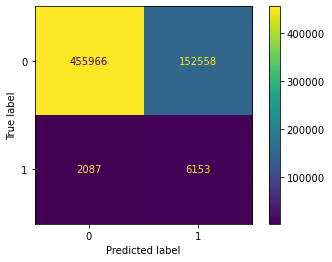

In [17]:
plot_confusion_matrix(search, X_test, y_test, labels = [0, 1])

<AxesSubplot:>

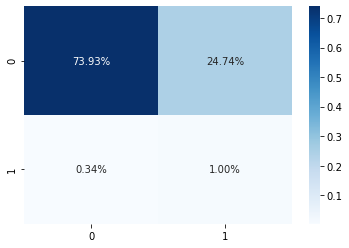

In [92]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [42]:
print(classification_report(y_test,y_pred, target_names=['Not Fatal', 'Fatal']))

              precision    recall  f1-score   support

   Not Fatal       0.99      0.73      0.84    608524
       Fatal       0.03      0.71      0.07      8240

    accuracy                           0.73    616764
   macro avg       0.51      0.72      0.45    616764
weighted avg       0.98      0.73      0.83    616764



In [20]:
y_pred_proba = search.predict_proba(X_test)[:,1]
y_pred_proba = y_pred_proba.reshape(-1, 1)
y_pred_proba.shape

(616764, 1)

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [ ]:
#plot ROC Curve





plt.plot([0,1],[0,1], "k--")
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression')

I dont find this model/classifier's performance to be great, but it does "catch" a the majority of the 'Fatal' category. 

There are 8240 fatal responses in the test set, and this classifier predicts ~75 % of those correctly. It does this however, at the cost of predicting many more fatalitie than actualy exist in the test set. It predicts roughly 158,000 fatalities out of a test set of 616764 observations.


# Random Forest Modelling - Fatal vs. Non-Fatal

This model investigate the random forest classifeir on a binary response, Fatal or Non-Fatal, using RandomSearchCV, as the times to use GridSearchCV would be very high.

In [24]:
#RandomForestClassifier?

In [ ]:
# Random Forest class with Class weights

clf = RandomForestClassifier()

random_grid ={'max_depth': [2,5,7],
             'min_samples_leaf': [1, 3, 5],
             'min_samples_split': [2, 3, 4, 5],
             'n_estimators': [100],
             'class_weight' : ["balanced"]
             }

rfclf = RandomizedSearchCV(clf, param_distributions = random_grid, n_jobs=1)

Train model, save to disk, all commented out because this woudl take several hours if fit every time the notebook was run. 

In [ ]:
#Train Random Forest

#start = time.time()
#rfclf.fit(X_train, y_train)
#message("Train_time="+str(round(((time.time()-start) /3600),3)) + ' hours')

In [ ]:
#save Model to disk

#with open('../models/rfmodel.pkl', 'wb') as file:
#    pickle.dump(rfclf, file)

In [29]:
rfclf = pickle.load(open('../models/rfmodel.pkl', 'rb'))


In [93]:
y_pred = rfclf.predict(X_test)

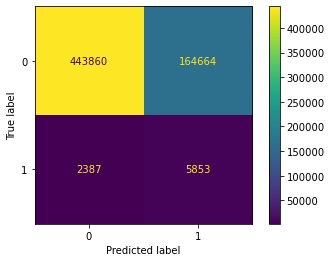

In [59]:
plot_confusion_matrix(rfclf, X_test, y_test, labels = [0, 1])

<AxesSubplot:>

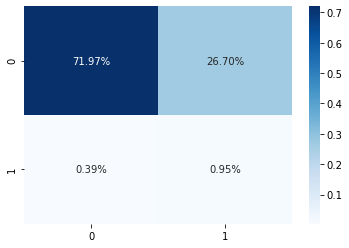

In [94]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [45]:
print(classification_report(y_test, y_pred, target_names=['Not Fatal', 'Fatal']))

              precision    recall  f1-score   support

   Not Fatal       0.99      0.73      0.84    608524
       Fatal       0.03      0.71      0.07      8240

    accuracy                           0.73    616764
   macro avg       0.51      0.72      0.45    616764
weighted avg       0.98      0.73      0.83    616764



In [ ]:
y_pred_proba = rfclf.predict_proba(X_test)[:,1]
y_pred_proba = y_pred_proba.reshape(-1, 1)
y_pred_proba.shape

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [ ]:
plt.plot([0,1],[0,1], "k--")
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest Model')

This model peformes slightly wors than the logistic model, and 
will not be selected

# XGB on Binary response (Fatal vs not Fatal)

Importing and using the XGB classifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
#XGBClassifier?

In [47]:
compute_sample_weight(class_weight='balanced', y=y_train)

array([0.50670317, 0.50670317, 0.50670317, ..., 0.50670317, 0.50670317,
       0.50670317])

In [48]:
xgbclf = XGBClassifier()
param_grid = {'max_depth': [1, 5, 10],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100],
        'scale_pos_weight' : [(y_train==0).sum()/ (y_train==1).sum()]}

Imbalanced Classes, Ratio of Non-Fatal/Fatal

In [51]:
#Manual computer Class Weight/Ratio
(y_train==0).sum()/ (y_train==1).sum()

74.59160626116189

In [50]:
rdmxgb = RandomizedSearchCV(xgbclf, param_distributions = param_grid, n_jobs=1)

Fit and save/export model, this step would take several hours so it is commented out so it will nto run every time the model runs

In [ ]:
#Fit RandomSearch XGB Classifier


#start = time.time()
#rdmxgb.fit(X_train, y_train)
#message('Train_time='+str(round(((time.time()-start) /3600),3)) + ' hours')

In [ ]:
#Save Classifer to disk

#with open('../models/xgbmodel.pkl', 'wb') as file:
#    pickle.dump(rdmxgb, file)

In [52]:
rdmxgb = pickle.load(open('../models/xgbmodel.pkl', 'rb'))

In [96]:
y_pred = rdmxgb.predict(X_test)

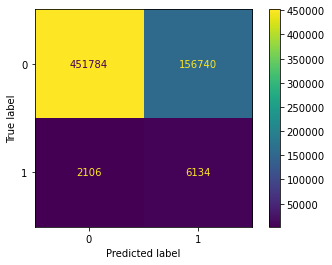

In [97]:
plot_confusion_matrix(rdmxgb, X_test, y_test, labels = [0, 1])


<AxesSubplot:>

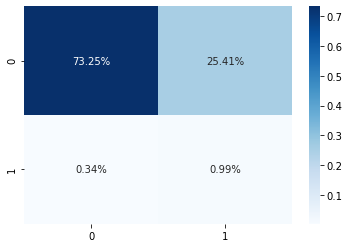

In [98]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [66]:
print(classification_report(y_test, y_pred, target_names=['Not Fatal', 'Fatal']))

              precision    recall  f1-score   support

   Not Fatal       1.00      0.74      0.85    608524
       Fatal       0.04      0.74      0.07      8240

    accuracy                           0.74    616764
   macro avg       0.52      0.74      0.46    616764
weighted avg       0.98      0.74      0.84    616764



In [67]:
y_pred_proba = rdmxgb.predict_proba(X_test)[:,1]
y_pred_proba = y_pred_proba.reshape(-1, 1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5, 1.0, 'ROC curve XGBoost Binary Model')

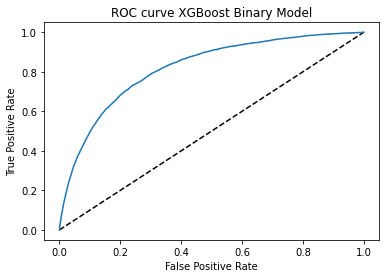

In [68]:
plt.plot([0,1],[0,1], "k--")
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve XGBoost Binary Model')

This model has a similar performance ot the Logistic model, although it classifies more as fatal that are not, and doesnt predict as many Fatal correctly, which is our goal, the Logistic Model is still superior.

# MultiClass  Modeling



# Logistic with Dummy variables

In [101]:
#Sklearn Logistic Regression Requires target be one dimensional

onedimy = y[y==1].stack().reset_index().drop(0,1).set_index('level_0')

onedimy.head(2)


,level_1
level_0,
1,Slight
2,Slight


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X,onedimy, test_size=0.30, random_state=42)
#y_train.head()

In [70]:
#Creating a RandomSearchCV for Logistic Regression, Multiclass

logmulti = LogisticRegression(solver='saga', 
                              tol=1e-2, 
                              max_iter=200,
                              random_state=1,
                              n_jobs=1,
                              class_weight='balanced',
                              multi_class='auto')
distributions = dict(C=np.arange(0,11), penalty=['l2','elasticnet'])
rdmlogmulti = RandomizedSearchCV(logmulti, distributions, random_state=0)

In [ ]:
#Fit Model and Save to disk


#rdmlogmulti.fit(X_train, y_train)
#with open('../models/rdmlogmulti.pkl', 'wb') as file:
#     pickle.dump(rdmlogmulti, file)


In [ ]:
#save model to disk

#with open('../models/rdmlogmulti.pkl', 'wb') as file:
#    pickle.dump(rdmlogmulti, file)

In [71]:
rdmlogmulti = pickle.load(open('../models/rdmlogmulti.pkl', 'rb'))

In [103]:
y_pred = rdmlogmulti.predict(X_test)

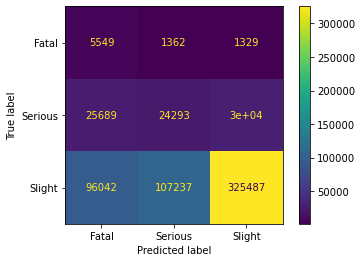

In [74]:
plot_confusion_matrix(rdmlogmulti, X_test, y_test)

<AxesSubplot:>

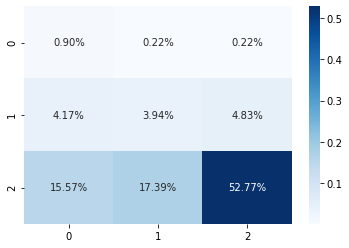

In [104]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Fatal       0.04      0.67      0.08      8240
     Serious       0.18      0.30      0.23     79758
      Slight       0.91      0.62      0.74    528766

    accuracy                           0.58    616764
   macro avg       0.38      0.53      0.35    616764
weighted avg       0.81      0.58      0.66    616764



# One Vs. Rest Classifier with Logistic Regression - Multiclass

In [ ]:
#instaniate Randomizedsearch for Logisitic Model One vs Rest

ovr=OneVsRestClassifier(LogisticRegression(solver='saga', 
                     tol=1e-2, 
                     max_iter=200,
                     random_state=1,
                     n_jobs=1,
                     class_weight='balanced',
                     multi_class='auto'))

distributions = dict(estimator__penalty=['l2','elasticnet'],
                     estimator__C=np.arange(1,11)
                    )

OVRrdm = RandomizedSearchCV(ovr, distributions, random_state=0)

In [ ]:

#OVRrdm.fit(X_train, y_train)
#with open('../models/OVRrdm.pkl', 'wb') as file:
#    pickle.dump(OVRrdm, file)


Load model and predict

In [111]:
OVRrdm = pickle.load(open('../models/OVRrdm.pkl', 'rb'))
y_pred= OVRrdm.predict(X_test)

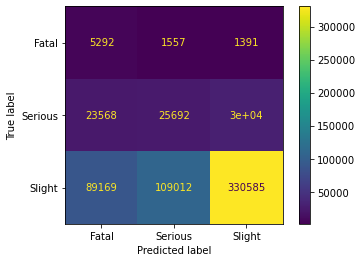

In [113]:
plot_confusion_matrix(OVRrdm, X_test, y_test)

<AxesSubplot:>

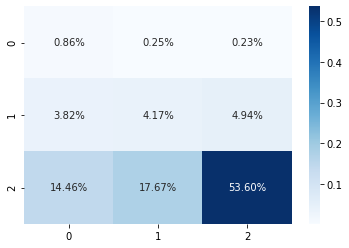

In [114]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [115]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Fatal       0.04      0.64      0.08      8240
     Serious       0.19      0.32      0.24     79758
      Slight       0.91      0.63      0.74    528766

    accuracy                           0.59    616764
   macro avg       0.38      0.53      0.35    616764
weighted avg       0.81      0.59      0.67    616764



# SMOTE + Logistic  - Multiclass Model

This model was looked at as an attempt to deal with the imbalanced classes within the dataset, by making many synthetic samples for training

In [117]:
#import
from imblearn.over_sampling import SMOTE

In [118]:
#slipt
X_train, X_test, y_train, y_test = train_test_split(X,onedimy, test_size=0.30, random_state=42)

This step is commented out becasue of the time it takes to create the syntetic samples, and the model ans been created/fit/saved already  below

In [119]:
#instantiate/fit --create synthetic data
#oversample = SMOTE()
#X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
#X_train.shape, y_train.shape

In [ ]:
ovr=OneVsRestClassifier(LogisticRegression(solver='saga', 
                     tol=1e-2, 
                     max_iter=200,
                     random_state=1,
                     n_jobs=1,
                     class_weight='balanced',
                     multi_class='auto'))

distributions = dict(estimator__penalty=['l2','elasticnet'],
                     estimator__C=np.arange(1,11)
                    )

OVR_rdm_SMOTE = RandomizedSearchCV(ovr, distributions, random_state=0)

In [ ]:
#OVR_rdm_SMOTE.fit(X_train, y_train)
#with open('../models/OVR_rdm_SMOTE.pkl', 'wb') as file:
#    pickle.dump(OVR_rdm_SMOTE, file)

Load model and predict

In [121]:
OVR_rdm_SMOTE = pickle.load(open('../models/OVR_rdm_SMOTE.pkl', 'rb'))
y_pred = OVR_rdm_SMOTE.predict(X_test)

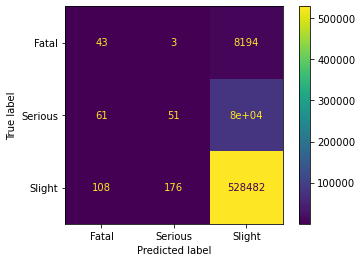

In [122]:
#y_pred = OVR_rdm_SMOTE.predict(X_test)
plot_confusion_matrix(OVR_rdm_SMOTE, X_test, y_test)

The combonation of SMOTE, Logistic/One Vs. Rest, produced a poor model. It end up classifying most observations as "Slight"